In [1]:
from dm_control import suite

In [2]:
env = suite.load('cartpole', 'swingup')
pixels = env.physics.render()

In [6]:
from PIL import Image
Image.fromarray(pixels).show()

In [7]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation


# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image

In [9]:
%config InlineBackend.figure_format = 'svg'

In [8]:
# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [10]:
# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

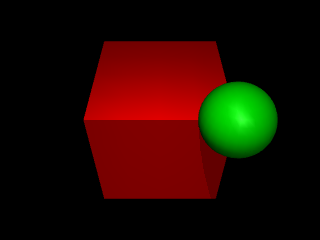

In [17]:
#@title A static model {vertical-output: true}

static_model = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1" pos="0 0.4 0"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(static_model)
pixels = physics.render()
PIL.Image.fromarray(pixels)

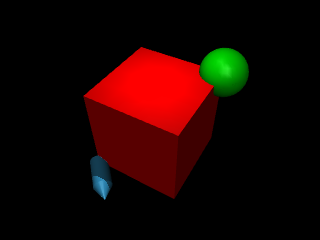

In [23]:
#@title A child body with a joint { vertical-output: true }

swinging_body = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(swinging_body)
# Visualize the joint axis.
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

In [25]:
#@title Making a video {vertical-output: true}

duration = 2    # (seconds)
framerate = 30  # (Hz)

# Visualize the joint axis
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True

# Simulate and display video.
frames = []
physics.reset()  # Reset state and time
while physics.data.time < duration:
  physics.step()
  if len(frames) < physics.data.time * framerate:
    pixels = physics.render(scene_option=scene_option)
    frames.append(pixels)
display_video(frames, framerate)

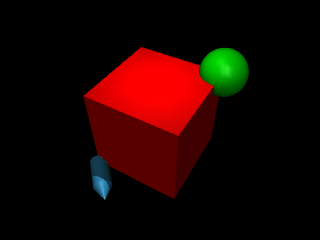

In [30]:
Image.fromarray(frames[0])

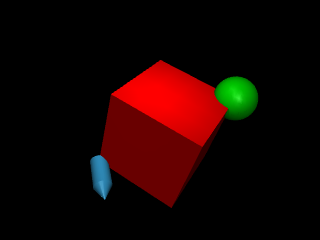

In [34]:
Image.fromarray(frames[5])

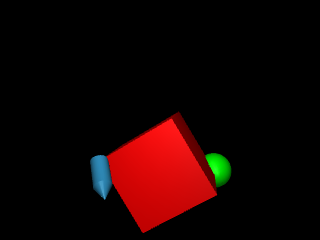

In [35]:
Image.fromarray(frames[10])

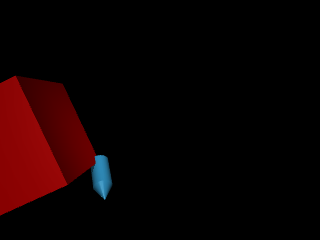

In [37]:
Image.fromarray(frames[30])